In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import polars as pl
from arjun_plot.statgen import *
from arjun_plot.utils import *
from tqdm import tqdm
from glob import glob

plt.rcParams['font.family'] = 'Arial'

%matplotlib inline

In [2]:
# Read in the GWAS summary stats
%time discovery_gwas_df = pl.read_csv('/scratch16/rmccoy22/scarios1/sandbox/maternal_meiotic_aneuploidy_gwas_scratch/lmm_gwas_maternal_meiotic_aneuploidy_by_mother_discovery_total_colnames.tsv.gz', separator="\t")
discovery_gwas_df = discovery_gwas_df.with_columns(pl.col('snp_id').str.split(':').list.get(0).alias('CHROM'))
discovery_gwas_filt_df = discovery_gwas_df.unique('snp_id')
discovery_gwas_filt_df.head()

CPU times: user 16.4 s, sys: 2.07 s, total: 18.5 s
Wall time: 6.43 s


pos,snp,beta,se,t,p.value,af,snp_id,effect_allele,chr,drop,ref,alt,CHROM
i64,str,f64,f64,f64,f64,f64,str,str,i64,i64,str,str,str
92087398,"""chr10:92087398:C:T_T""",0.680831,0.230059,2.959377,0.003083,0.000569,"""chr10:92087398:C:T""","""T""",10,0,"""T""","""C""","""chr10"""
52580600,"""chr20:52580600:T:C_C""",-0.000454,0.015518,-0.029234,0.976678,0.16382,"""chr20:52580600:T:C""","""C""",20,0,"""C""","""T""","""chr20"""
41036668,"""chr12:41036668:G:C_C""",-0.064538,0.112863,-0.571821,0.567443,0.002541,"""chr12:41036668:G:C""","""C""",12,0,"""C""","""G""","""chr12"""
118889316,"""chr4:118889316:G:A_A""",0.005465,0.205631,0.026579,0.978796,0.000691,"""chr4:118889316:G:A""","""A""",4,0,"""A""","""G""","""chr4"""
2625706,"""chr17:2625706:G:T_T""",0.000118,0.013235,0.008927,0.992877,0.266447,"""chr17:2625706:G:T""","""T""",17,0,"""T""","""G""","""chr17"""


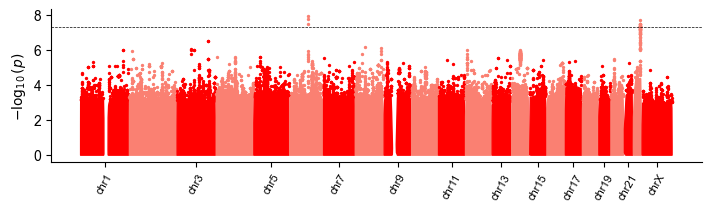

In [3]:
fig, ax = plt.subplots(1,1, figsize=(7,2), layout='constrained')

def gwas_plot(ax0, colors=['red', 'salmon'], odds=False):
    _, xpos = manhattan_plot(ax=ax0, chroms=discovery_gwas_filt_df['CHROM'].to_numpy(), 
               pos=discovery_gwas_filt_df['pos'].to_numpy(), 
               pvals=discovery_gwas_filt_df['p.value'].to_numpy(), q=0.9995, thin=1, colors=colors, s=2, padding=5e6)

    ax0.axhline(-np.log10(5e-8), linestyle='--', lw=0.5, color='black')
    chroms = [f'chr{i}' for i in range(1,23)] + ['chrX']
    if odds:
        ax0.set_xticks(xpos[::2])
        ax0.set_xticklabels(chroms[::2], rotation=60, fontsize=8)
    else:    
        ax0.set_xticks(xpos)
        ax0.set_xticklabels(chroms, rotation=60, fontsize=8)
    ax0.set_ylabel(r'$-\log_{10}(p)$')
    debox(ax0)

gwas_plot(ax, odds=True)

In [4]:
# Isolating potential "lead variants" for locuszoom efforts
discovery_gwas_filt_df.filter(pl.col('p.value') < 5e-8).sort('p.value').unique('CHROM')

pos,snp,beta,se,t,p.value,af,snp_id,effect_allele,chr,drop,ref,alt,CHROM
i64,str,f64,f64,f64,f64,f64,str,str,i64,i64,str,str,str
45387213,"""chr22:45387213:T:C_C""",0.066541,0.011849,5.615838,1.9561e-8,0.406054,"""chr22:45387213:T:C""","""C""",22,0,"""C""","""T""","""chr22"""
93122386,"""chr6:93122386:G:A_G""",0.079971,0.014029,5.700423,1.1951e-8,0.224465,"""chr6:93122386:G:A""","""G""",6,0,"""G""","""A""","""chr6"""


575it [00:03, 159.58it/s]
/tmp/ipykernel_3182292/2381518167.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{i:.2f}' for i in ax1.get_xticks() / 1e6])
/home/abiddan1/bin/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/abiddan1/bin/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


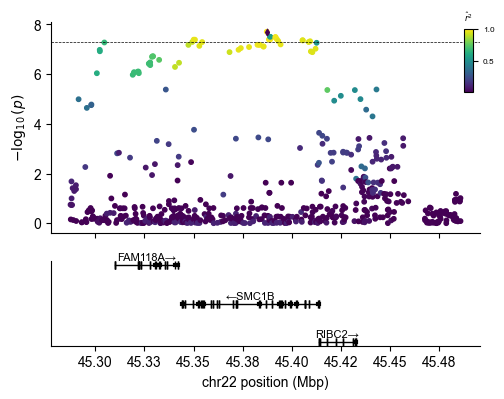

In [5]:
def full_locuszoom_alt(ax0, ax1, gwas_df, lead_variant, vcf_filepath = '/data/rmccoy22/natera_spectrum/genotypes/imputed_parents_101823_cpra/', lower_window_size=1e5, upper_window_size=1e5, yoff=0.2, fontsize=8, scaling_factor=0.05, name_filt=[]):
    """Given a lead variant run a locuszoom plot using the vcf_filepath to imputed data (using cyvcf2)"""
    chrom = lead_variant.split(":")[0]
    pos = int(lead_variant.split(":")[1])
    # Calculate LD
    vcf_fp = glob(f'{vcf_filepath}*_{chrom}_*.vcf.gz')
    variant_ids, R2 = extract_ld_matrix(vcf_fp=vcf_fp[0], chrom=chrom, position_min=int(pos-lower_window_size), position_max=int(pos+upper_window_size))
    ax0, im  = locuszoom_plot(ax0, 
                   chroms=gwas_df['CHROM'].to_numpy(), 
                   pos = gwas_df['pos'].to_numpy(), 
                   pvals=gwas_df['p.value'].to_numpy(),
                   variants=gwas_df['snp_id'].to_numpy(), ld_matrix=R2, ld_variant_ids=variant_ids, lead_variant=lead_variant,
                   chrom=chrom, position_min=int(pos-lower_window_size), position_max=int(pos+upper_window_size), s=10)
    divider = make_axes_locatable(ax0)
    cax = inset_axes(ax0, width="2%", height="30%", loc='upper right') 
    cbar = fig.colorbar(im, cax=cax, ticks=[0.0, 0.5, 1.0])
    cbar.ax.tick_params(labelsize=6) 
    cbar.ax.set_title(label=r'$\hat{r}^2$', fontsize=6)
    ax1 = gene_plot(ax1, chrom=chrom, position_min=int(pos-lower_window_size), position_max=int(pos+upper_window_size), yoff=yoff, fontsize=fontsize, scaling_factor=scaling_factor, name_filt=name_filt);
    ax1.sharex(ax0);
    ax0.set_ylabel(r'$-\log_{10}(p)$')
    ax1.set_yticks([]);
    ax1.set_xticklabels([f'{i:.2f}' for i in ax1.get_xticks() / 1e6])
    ax1.set_xlabel(f'{chrom} position (Mbp)')
    ax0.axhline(-np.log10(5e-8), lw=0.5, linestyle='--', color='black')
    debox(ax0); debox(ax1);
    return [ax0, ax1], variant_ids, R2

fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col',
                               gridspec_kw={'height_ratios': [5, 2]},
                               figsize=(5, 4), layout='tight')

full_locuszoom_alt(ax[0], ax[1], gwas_df=discovery_gwas_filt_df, lead_variant='chr22:45387213:T:C', yoff=0.1, name_filt=['^LOC']);

1598it [00:09, 163.18it/s]
/tmp/ipykernel_3182292/2381518167.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{i:.2f}' for i in ax1.get_xticks() / 1e6])
/home/abiddan1/bin/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/abiddan1/bin/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


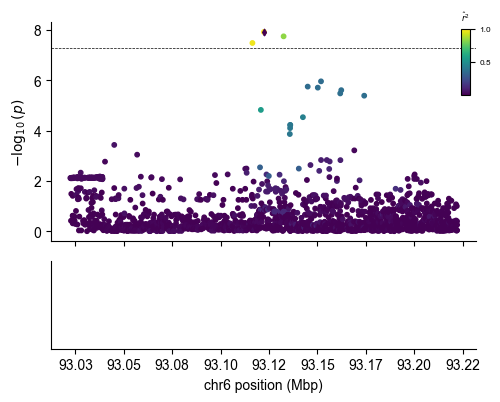

In [6]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col',
                               gridspec_kw={'height_ratios': [5, 2]},
                               figsize=(5, 4), layout='tight')

full_locuszoom_alt(ax[0], ax[1], gwas_df=discovery_gwas_filt_df, lead_variant='chr6:93122386:G:A', yoff=0.1, name_filt=['^LOC']);

In [7]:
# Data for Figure 2C (fitted from a binomial model)
model_fig2c_df = pl.read_csv('../../sandbox/figure2c_data/fig2c_figure_input.txt', separator="\t")
model_fig2c_df.head()

patient_age_cycle,genotype,p_aneuploidy
i64,str,f64
20,"""AA""",0.016296
20,"""AG""",0.015252
20,"""GG""",0.014274
21,"""AA""",0.018868
21,"""AG""",0.017663


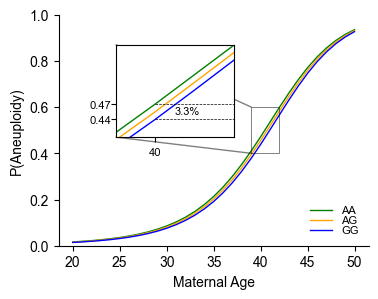

In [8]:
fig, ax = plt.subplots(1,1,figsize=(4,3))

def plot_figure2c(ax, colors=['green','orange', 'blue']):
    for i, geno in enumerate(['AA', 'AG', 'GG']):
        df = model_fig2c_df.filter(pl.col('genotype') == geno)
        ax.plot(df['patient_age_cycle'].to_numpy(), df['p_aneuploidy'].to_numpy(), color=colors[i], lw=1, label=f'{geno}')
    ax.set_xlabel('Maternal Age')
    ax.set_ylabel('P(Aneuploidy)')
    ax.set_ylim(0,1)
    axins = inset_axes(ax,
                        width="40%", # width = 30% of parent_bbox
                        height="40%", # height : 1 inch
                        loc='upper center', bbox_to_anchor=(-0.1, -0.1, 0.95, 1), bbox_transform=ax.transAxes)
    for i, geno in enumerate(['AA', 'AG', 'GG']):
        df = model_fig2c_df.filter(pl.col('genotype') == geno)
        axins.plot(df['patient_age_cycle'].to_numpy(), df['p_aneuploidy'].to_numpy(), color=colors[i],  lw=1, label=f'{geno}')
    axins.set_xlim(39, 42)
    axins.set_ylim(0.4, 0.6)
    box, c1 = ax.indicate_inset_zoom(axins, edgecolor="black", alpha=0.5, lw=0.7)
    c1[0].set_visible(True)
    c1[1].set_visible(True)
    # c1[2].set_visible(True)
    # c1[3].set_visible(True)
    x1 = model_fig2c_df.filter(pl.col('genotype') == 'AA').filter(pl.col('patient_age_cycle') == 40)['p_aneuploidy'].to_numpy()[0]
    x2 = model_fig2c_df.filter(pl.col('genotype') == 'GG').filter(pl.col('patient_age_cycle') == 40)['p_aneuploidy'].to_numpy()[0]
    axins.plot([40,42],[x1,x1], linestyle='--', lw=0.5, color='black')
    axins.plot([40,42],[x2,x2], linestyle='--', lw=0.5, color='black')
    axins.text(40.5,(x1+x2)/2, f'{(x1-x2)*100:.1f}%', va='center', ha='left', fontsize=8)
    ax.legend(fontsize=8, frameon=False, labelspacing=0, loc='lower right')
    axins.set_xticks([40]); axins.set_xticklabels(['40'], fontsize=8)
    axins.set_yticks([x1,x2]); axins.set_yticklabels([f'{x1:.2f}',f'{x2:.2f}'], fontsize=8);
    axins.tick_params(axis='y', pad=0.1);
    debox(ax)
    return ax

plot_figure2c(ax);

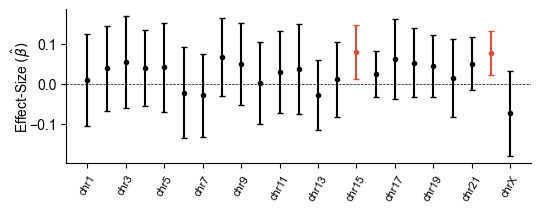

In [9]:
# Data for Supp figure on per-chromosome effects
per_chromosome_effect_df = pl.read_csv('/scratch16/rmccoy22/scarios1/sandbox/maternal_meiotic_aneuploidy_gwas_scratch/single_chr/single_chr_x_gwas_1024_imputation.txt', separator=",")
fig, ax = plt.subplots(1,1,figsize=(6,2))

def plot_per_chromosome_effects(ax, sig_color='blue'):
    chroms = range(1,24)
    for i,x in enumerate(chroms):
        cur_df = per_chromosome_effect_df.filter(pl.col('chromosome') == x)
        if cur_df['p.value'].to_numpy()[0] < 0.05:
            ax.errorbar(i, cur_df['beta'].to_numpy(), 
                        yerr=[cur_df['beta'].to_numpy() - cur_df['conf_lower'].to_numpy(), cur_df['conf_upper'].to_numpy() - cur_df['beta'].to_numpy()],
                        color=sig_color, capsize=2, marker='.')
        else:    
            ax.errorbar(i, cur_df['beta'].to_numpy(), 
                        yerr=[cur_df['beta'].to_numpy() - cur_df['conf_lower'].to_numpy(), cur_df['conf_upper'].to_numpy() - cur_df['beta'].to_numpy()], capsize=2, marker='.', color='black')
    ax.axhline(0.0, linestyle='--', lw=0.5, color='black')
    chrom_lbl = [f'chr{i}' for i in range(1,23)] + ['chrX']
    xpos = range(23)
    ax.set_xticks(xpos[::2])
    ax.set_xticklabels(chrom_lbl[::2], rotation=60, fontsize=8)
    ax.set_ylabel(r'Effect-Size $(\hat{\beta})$', labelpad=-3)
    debox(ax);

plot_per_chromosome_effects(ax, sig_color="#E64B35FF");


In [10]:
def plot_figure2a(ax):
    """Rough function for plotting of Figure 2a results from mixed-model."""
    ax.errorbar(0, 2.239, yerr=[[2.239-2.231], [2.246-2.239]], marker='.', color='black', capsize=2)
    ax.errorbar(1, 2.092, yerr=[[2.092 - 2.085], [2.1-2.092]], marker='.', color='black', capsize=2)
    ax.set_ylabel('CO rate\n (per chromosome)')
    ax.set_xticks([0,1])
    ax.set_xticklabels(['Euploid', 'Aneuploid'])
    debox(ax)
    return ax

636it [00:04, 154.45it/s]
/tmp/ipykernel_3182292/2381518167.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels([f'{i:.2f}' for i in ax1.get_xticks() / 1e6])


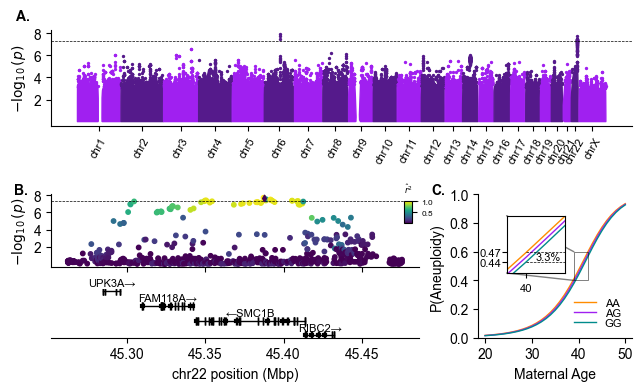

In [11]:
fig = plt.figure(figsize=(7.5, 4))
spec = fig.add_gridspec(14, 9, hspace=10.0, wspace=5)


ax0 = fig.add_subplot(spec[:5, :])
# gwas_plot(ax0, colors=["#DC0000FF", "#DC000099"], odds=True)
gwas_plot(ax0, colors=["#A020F0", "#551A8B"], odds=False)
ax0.set_yticks([2,4,6,8]); ax0.set_yticklabels([2,4,6,8]);


ax1 = fig.add_subplot(spec[7:, 6:])
plot_figure2c(ax1, colors=['#FF8C00', '#A020F0', '#008B8B'])
ax1.set_xticks([20,30,40,50])
ax1.set_xticklabels([20,30,40,50])

ax11 = fig.add_subplot(spec[7:11, :6])
ax11.set_yticks([2,4,6,8]); ax11.set_yticklabels([2,4,6,8]);
ax11b = fig.add_subplot(spec[11:, :6])

full_locuszoom_alt(ax11, ax11b, gwas_df=discovery_gwas_filt_df, lead_variant='chr22:45387213:T:C', lower_window_size=1.25e5, upper_window_size=9e4, 
                   yoff=0.25, fontsize=8, scaling_factor=0.05, name_filt=['^LOC']);
plt.setp(ax11.get_xticklabels(), visible=False)
ax11b.spines['left'].set_visible(False)

# fig.suptitle('Manually added subplots, spanning a column')
label_multipanel([ax0], ['A.'], xoff=-0.06, yoff=1.1, fontweight='bold')
label_multipanel([ax1], ['C.'], xoff=-0.3, yoff=1.0, fontweight='bold', zorder=10)

label_multipanel([ax11], ['B.'], fontweight='bold', xoff=-0.1, yoff=1.0)
plt.savefig('figure2.010825.v5.pdf', bbox_inches='tight')
plt.savefig('figure2.010825.v5.png', dpi=300, bbox_inches='tight')